In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable

In [2]:
# letting n = 5
grid = torch.linspace(0, 1, 5)
x, y = torch.meshgrid(grid[1:-1], grid[1:-1], indexing='xy')
print("grid = ",grid)
print("x = ", x)
print("y = ", y)
# print(x,y)
print("flatten, reshape = ", x.flatten().reshape((5-2)**2, 1))
print("concatenate = ", torch.cat((x.flatten().reshape((5-2)**2, 1), y.flatten().reshape((5-2)**2, 1)), 1))
print("boundary = ", torch.cat((torch.zeros_like(grid).reshape(5, 1), grid.reshape(5, 1)), 1))
# torch.cat((x,x))

grid =  tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
x =  tensor([[0.2500, 0.5000, 0.7500],
        [0.2500, 0.5000, 0.7500],
        [0.2500, 0.5000, 0.7500]])
y =  tensor([[0.2500, 0.2500, 0.2500],
        [0.5000, 0.5000, 0.5000],
        [0.7500, 0.7500, 0.7500]])
flatten, reshape =  tensor([[0.2500],
        [0.5000],
        [0.7500],
        [0.2500],
        [0.5000],
        [0.7500],
        [0.2500],
        [0.5000],
        [0.7500]])
concatenate =  tensor([[0.2500, 0.2500],
        [0.5000, 0.2500],
        [0.7500, 0.2500],
        [0.2500, 0.5000],
        [0.5000, 0.5000],
        [0.7500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.7500],
        [0.7500, 0.7500]])
boundary =  tensor([[0.0000, 0.0000],
        [0.0000, 0.2500],
        [0.0000, 0.5000],
        [0.0000, 0.7500],
        [0.0000, 1.0000]])


In [3]:
def training_vanilla(loss_function, boundary_function, n_inputs, n_outputs,
                     n_training, num_epochs, batch_size_interior, batch_size_boundary,
                     H, gamma, lr, lr_decay_steps, lr_decay_rate):

    # initialise the model

    model = NN_DE(H, n_inputs, n_outputs)

    optimiser = opt.Adam(model.parameters(), lr=lr)
    scheduler = opt.lr_scheduler.StepLR(optimiser, step_size=lr_decay_steps, gamma=lr_decay_rate)

    model.train()

    grid = torch.linspace(space_range[0], space_range[1], n)
    # ignoring the boundary indices and creating grids of x and y coordinates
    x, y = torch.meshgrid(grid[1:-1], grid[1:-1], indexing='xy')
    # gives (n-2)**2 x 2 array of coordinates of all interior mesh points, going through y then x
    grid_interior = torch.cat((x.flatten().reshape((n-2)**2, 1), y.flatten().reshape((n-2)**2, 1)), 1)
    # gives n x 2 array of coordinates of all boundary mesh points
    grid_boundary_1 = torch.cat((torch.zeros_like(grid).reshape(n, 1), grid.reshape(n, 1)), 1)
    grid_boundary_2 = torch.cat((space_range[1]*torch.ones_like(grid).reshape(n, 1), grid.reshape(n, 1)), 1)
    grid_boundary_3 = torch.cat((grid.reshape(n, 1), torch.zeros_like(grid).reshape(n, 1)), 1)
    grid_boundary_4 = torch.cat((grid.reshape(n, 1), space_range[1]*torch.ones_like(grid).reshape(n, 1)), 1)
    # gives 4n x 2 array of coordinates of boundary values
    grid_boundary = torch.cat((grid_boundary_1, grid_boundary_2, grid_boundary_3, grid_boundary_4))

    train_loss_vanilla = []

    for epoch in range(num_epochs):

        # loss in each epoch
        train_loss_vanilla_epoch = []

        # shuffle the data
        index_interior = torch.randperm(len(grid_interior))
        train_interior = grid_interior[index_interior]

        for i in range(0, len(train_interior), batch_size_interior):

            # mini-batch
            batch_interior = train_interior[i:i+batch_size_interior, :]
            batch_interior = Variable(batch_interior, requires_grad=True)
            # gives a batch_size_boundary x 1 array of random integers in [0,len(grid_boundary)]
            index_boundary = torch.randint(len(grid_boundary), (batch_size_boundary,))
            batch_boundary = grid_boundary[index_boundary, :]
            batch_boundary = Variable(batch_boundary, requires_grad=True)

            loss = loss_function(batch_interior, batch_boundary, boundary_function, space_range, model, gamma)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            train_loss_vanilla_epoch.append(loss)

        train_loss_vanilla.append(sum(train_loss_vanilla_epoch)/(n_training/batch_size_interior))

        scheduler.step()

        if ( epoch%lr_decay_steps==(lr_decay_steps-1) ):

            print('Epochs %i/%i. Loss: %.8f.' %(epoch+1, num_epochs, train_loss_vanilla[-1]))

    return train_loss_vanilla, model

def training_modified(loss_function, prediction2output, n_inputs, n_outputs,
                      n_training, num_epochs, batch_size,
                      H, lr, lr_decay_steps, lr_decay_rate):

    # initialise the model

    model = NN_DE(H, n_inputs, n_outputs)

    optimiser = opt.Adam(model.parameters(), lr=lr)
    scheduler = opt.lr_scheduler.StepLR(optimiser, step_size=lr_decay_steps, gamma=lr_decay_rate)

    model.train()

    grid = torch.linspace(space_range[0], space_range[1], n)
    x, y = torch.meshgrid(grid, grid, indexing='xy')
    grid_all = torch.cat((x.flatten().reshape(n**2, 1), y.flatten().reshape(n**2, 1)), 1)
    train_loss_modified = []

    for epoch in range(num_epochs):

        train_loss_modified_epoch = []

        index = torch.randperm(len(grid_all))
        train_all = grid_all[index]

        for i in range(0, len(train_all), batch_size):

            batch_all = train_all[i:i+batch_size, :]
            batch_all = Variable(batch_all, requires_grad=True)

            loss = loss_function(batch_all, prediction2output, model)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            train_loss_modified_epoch.append(loss*len(batch_all))

        train_loss_modified.append(sum(train_loss_modified_epoch)/len(train_all))

        scheduler.step()

        if ( epoch%lr_decay_steps==(lr_decay_steps-1) ):

            print('Epochs %i/%i. Loss: %.8f.' %(epoch+1, num_epochs, train_loss_modified[-1]))

    return train_loss_modified, model

In [4]:
# define the class for the NN model

class NN_DE(nn.Module):

    def __init__(self, H, n_inputs, n_outputs):
        super(NN_DE, self).__init__()
        self.activation = nn.ELU()
        self.fc1 = nn.Linear(n_inputs, H)
        self.fc2 = nn.Linear(H, H)
        # self.fc3 = nn.Linear(H, H)
        # self.fc4 = nn.Linear(H, H)
        # self.fc5 = nn.Linear(H, H)
        self.fc6 = nn.Linear(H, n_outputs)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        # x = self.activation(x)
        # x = self.fc3(x)
        # x = self.activation(x)
        # x = self.fc4(x)
        # x = self.activation(x)
        # x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)
        return x

In [5]:
# define common used parameters

# training points

n_training_list = [16, 32, 64]
space_range = [0, 1]

# parameters for training

H = 128
batch_size_interior = 16
batch_size_boundary = 4
num_epochs = 100
lr = 0.01
lr_decay_steps = int(num_epochs/10)
lr_decay_rate = 0.5

# dimension of variable and number of equations in the system

n_inputs = 2
n_outputs = 1

In [6]:
# solving problem 5 from the paper "Artificial Neural Networks for Solving Ordinary and Partial Differential Equations"

# vanilla model

# weight of terms about boundary condition in the loss function

gamma = 1

# boundary conditions (in the order left->right->bottom->top)

# Give a boundary_batch_size x 2 array of the batch of boundary grid points and a vector of your endpoints and this returns the boundary values of the function at these endpoints
def boundary_function(x, space_range):
    values = torch.zeros(len(x), 1)
    for i in range(len(x)):
        if ( x[i, 0]==space_range[0] ):  # left
            values[i] = x[i, 1]**3
        elif ( x[i, 0]==space_range[1] ):  # right
            values[i] = (1 + x[i, 1]**3)*torch.exp(-torch.ones(1, 1))
        elif ( x[i, 1]==space_range[0] ):  # bottom
            values[i] = x[i, 0]*torch.exp(-x[i, 0])
        elif ( x[i, 1]==space_range[1] ):  # top
            values[i] = (x[i, 0] + 1)*torch.exp(-x[i, 0])
        else:  # not on the boundary
            print('Not valid')
            return 0
    return values

# define the loss function for vanilla model

def loss_vanilla(batch_interior, batch_boundary, boundary_function, space_range, model, gamma):

    # compute the predicted y in the interior and on the boundary
    y_predict_interior = model(batch_interior)
    y_predict_boundary = model(batch_boundary)

    # compute the target value on the boundary
    y_target_boundary = boundary_function(batch_boundary, space_range)

    # compute the gradient of y_hat w.r.t. x
    grad = torch.autograd.grad(y_predict_interior, batch_interior, grad_outputs=torch.ones_like(y_predict_interior),
                                 retain_graph=True, create_graph=True)[0]
    hess = torch.autograd.grad(grad, batch_interior, grad_outputs=torch.ones_like(grad),
                                 retain_graph=True, create_graph=True)[0]

    # loss = interior_difference**2 + boundary_difference**2
    loss = (((hess[:, 0] + hess[:, 1] - torch.exp(-batch_interior[:, 0])*(batch_interior[:, 0] - 2 + batch_interior[:, 1]**3 + 6*batch_interior[:, 1]))**2).mean()
            + (gamma*((y_predict_boundary - y_target_boundary)**2)).mean())

    return loss

models_vanilla = []

for n in n_training_list:

    train_loss_vanilla, model_vanilla = training_vanilla(loss_vanilla, boundary_function, n_inputs, n_outputs,
                                                         n, num_epochs, batch_size_interior, batch_size_boundary,
                                                         H, gamma, lr, lr_decay_steps, lr_decay_rate)
    models_vanilla.append(model_vanilla)

Epochs 10/100. Loss: 0.60656178.
Epochs 20/100. Loss: 0.22830570.
Epochs 30/100. Loss: 0.16441981.
Epochs 40/100. Loss: 0.09418998.
Epochs 50/100. Loss: 0.08863509.
Epochs 60/100. Loss: 0.06973386.
Epochs 70/100. Loss: 0.07041639.
Epochs 80/100. Loss: 0.07087577.
Epochs 90/100. Loss: 0.07524683.
Epochs 100/100. Loss: 0.07633384.
Epochs 10/100. Loss: 0.46731848.
Epochs 20/100. Loss: 0.20035701.
Epochs 30/100. Loss: 0.11804657.
Epochs 40/100. Loss: 0.06241260.
Epochs 50/100. Loss: 0.04820509.
Epochs 60/100. Loss: 0.04803829.
Epochs 70/100. Loss: 0.03667391.
Epochs 80/100. Loss: 0.04407564.
Epochs 90/100. Loss: 0.03388716.
Epochs 100/100. Loss: 0.03044759.
Epochs 10/100. Loss: 1.10948002.
Epochs 20/100. Loss: 0.30608729.
Epochs 30/100. Loss: 0.18577488.
Epochs 40/100. Loss: 0.04637796.
Epochs 50/100. Loss: 0.03859882.
Epochs 60/100. Loss: 0.01846207.
Epochs 70/100. Loss: 0.03147209.
Epochs 80/100. Loss: 0.00968199.
Epochs 90/100. Loss: 0.01912505.
Epochs 100/100. Loss: 0.01171401.


Text(0.5, 0, 'z')

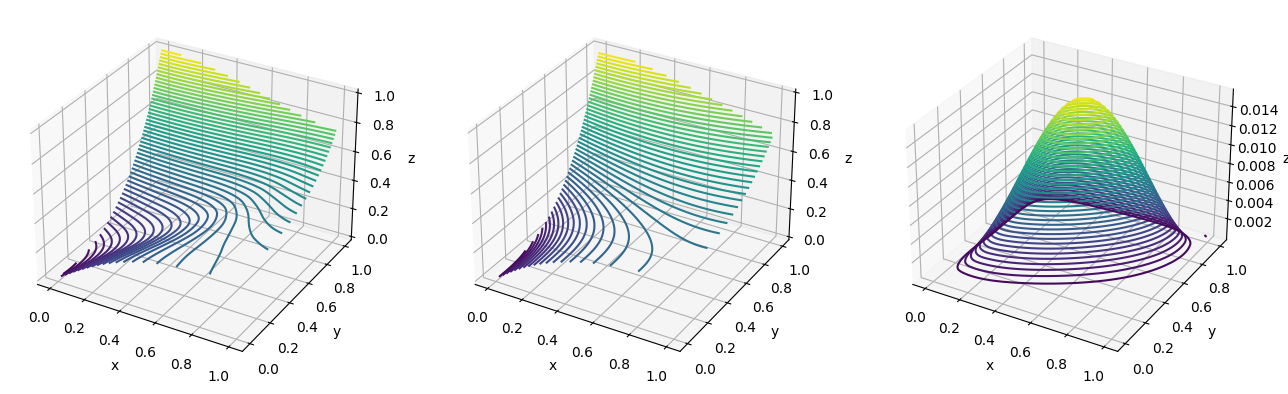

In [7]:
grid = torch.linspace(space_range[0], space_range[1], n)
x, y = torch.meshgrid(grid, grid, indexing='xy')
grid_all = torch.cat((x.flatten().reshape(n**2, 1), y.flatten().reshape(n**2, 1)), 1)
prediction = models_vanilla[-1](grid_all)
prediction = prediction.detach().numpy().reshape(n, n)
x = x.detach().numpy()
y = y.detach().numpy()
fig = plt.figure(figsize=[16, 8])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.contour3D(x, y, prediction, 50, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
z = np.exp(-x)*(x + y**3)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.contour3D(x, y, z, 50, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.contour3D(x, y, (z - prediction)**2, 50, cmap='viridis')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

In [8]:
# define common used parameters

# training points

n_training_list = [16, 32, 64]
space_range = [0, 1]

# parameters for training

H = 128
batch_size = 16
num_epochs = 100
lr = 0.01
lr_decay_steps = int(num_epochs/10)
lr_decay_rate = 0.5

# dimension of variable and number of equations in the system

n_inputs = 2
n_outputs = 1

In [9]:
# define the transform and the loss function for modified model

def prediction2output(inputs, model):

    prediction = model(inputs)
    x = inputs[:, 0].reshape(len(inputs), 1)
    y = inputs[:, 1].reshape(len(inputs), 1)
    output = ((1 - x)*y**3 + x*(1 + y**3)*torch.exp(-torch.ones(1, 1)) + (1 - y)*x*(torch.exp(-x) - torch.exp(-torch.ones(1, 1)))
              + y*((1 + x)*torch.exp(-x) - (1 - x + 2*x*torch.exp(-torch.ones(1, 1))))).reshape(len(prediction), 1) + x*(1 - x)*y*(1 - y)*prediction

    return output

def loss_modified(batch_all, prediction2output, model):

        # compute the predicted y in the interior and on the boundary
    output = prediction2output(batch_all, model)

    # compute the gradient of y_hat w.r.t. x
    grad = torch.autograd.grad(output, batch_all, grad_outputs=torch.ones_like(output),
                               retain_graph=True, create_graph=True)[0]
    hess = torch.autograd.grad(grad, batch_all, grad_outputs=torch.ones_like(grad),
                               retain_graph=True, create_graph=True)[0]

    # loss = interior_difference**2 + boundary_difference**2
    loss = ((hess[:, 0] + hess[:, 1] - torch.exp(-batch_all[:, 0])*(batch_all[:, 0] - 2 + batch_all[:, 1]**3 + 6*batch_all[:, 1]))**2).mean()

    return loss

models_modified = []

for n in n_training_list:

    train_loss_modified, model_modified = training_modified(loss_modified, prediction2output, n_inputs, n_outputs,
                                                            n, num_epochs, batch_size,
                                                            H, lr, lr_decay_steps, lr_decay_rate)

    models_modified.append(model_modified)

Epochs 10/100. Loss: 0.93950206.
Epochs 20/100. Loss: 0.85557067.
Epochs 30/100. Loss: 0.67315960.
Epochs 40/100. Loss: 0.61642271.
Epochs 50/100. Loss: 0.59014285.
Epochs 60/100. Loss: 0.58525199.
Epochs 70/100. Loss: 0.58007807.
Epochs 80/100. Loss: 0.57788342.
Epochs 90/100. Loss: 0.57679582.
Epochs 100/100. Loss: 0.57605594.
Epochs 10/100. Loss: 0.87719733.
Epochs 20/100. Loss: 0.49126881.
Epochs 30/100. Loss: 0.43790525.
Epochs 40/100. Loss: 0.41403466.
Epochs 50/100. Loss: 0.41207924.
Epochs 60/100. Loss: 0.40937856.
Epochs 70/100. Loss: 0.40017062.
Epochs 80/100. Loss: 0.39790195.
Epochs 90/100. Loss: 0.39650020.
Epochs 100/100. Loss: 0.39630127.
Epochs 10/100. Loss: 0.57896709.
Epochs 20/100. Loss: 0.53127450.
Epochs 30/100. Loss: 0.38648400.
Epochs 40/100. Loss: 0.35324317.
Epochs 50/100. Loss: 0.32065669.
Epochs 60/100. Loss: 0.30085802.
Epochs 70/100. Loss: 0.30622452.
Epochs 80/100. Loss: 0.30117840.
Epochs 90/100. Loss: 0.29970276.
Epochs 100/100. Loss: 0.29874390.


Text(0.5, 0, 'z')

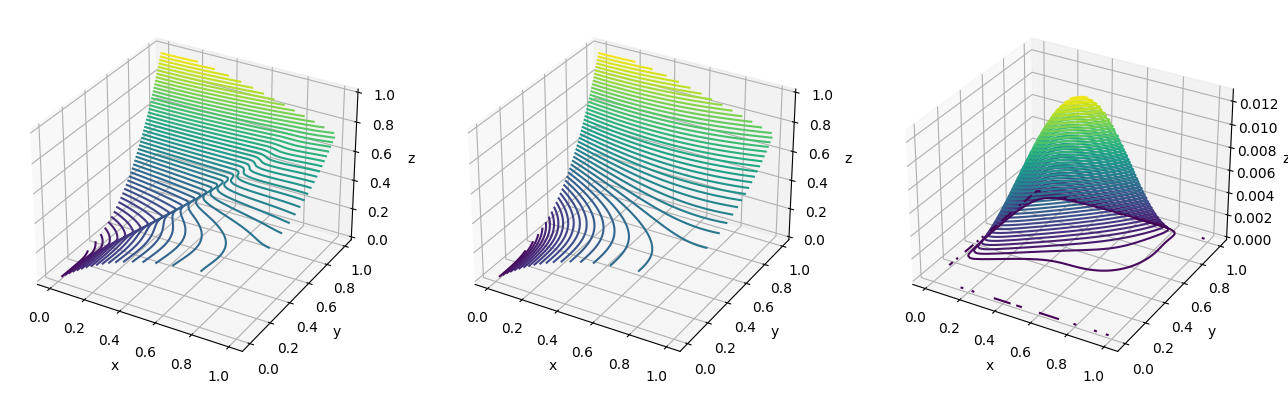

In [10]:
grid = torch.linspace(space_range[0], space_range[1], n)
x, y = torch.meshgrid(grid, grid, indexing='xy')
grid_all = torch.cat((x.flatten().reshape(n**2, 1), y.flatten().reshape(n**2, 1)), 1)
output = prediction2output(grid_all, models_modified[-1])
output = output.detach().numpy().reshape(n, n)
x = x.detach().numpy()
y = y.detach().numpy()
fig = plt.figure(figsize=[16, 8])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.contour3D(x, y, output, 50, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
z = np.exp(-x)*(x + y**3)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.contour3D(x, y, z, 50, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.contour3D(x, y, (z - output)**2, 50, cmap='viridis')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

In [11]:
((z - output)**2).mean()

0.0016110344